In [ ]:
%pip install geopandas
%pip install rasterio
%pip install scipy

# Develop and Test GIS Functions

This notebook is for developing and testing the GIS functions implemented in `functions.py` using open-source libraries such as geopandas, rasterio, numpy, and scipy.

In [ ]:
# Import Required Libraries
import os
import sys
import unittest
import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
import scipy
import rasterio
from rasterio.mask import mask


In [104]:
# Import functions from functions.py
cur_dir = os.path.abspath('.')
if cur_dir not in sys.path:
    sys.path.append(cur_dir)  # Ensure current directory is in path
sys.path

root_dir = os.path.abspath(f"..")
root_dir

'/Users/landy/UoW/COMPX576/code/site-analyzer'

In [ ]:
def RPL_Select_analysis(input_shp, output_shp, conditions_expression):
    """
    Selects features from the input shapefile based on a given expression and saves them to an output shapefile.
    
    Parameters:
    - input_shp: Path to the input shapefile.
    - output_shp: Path to save the output shapefile.
    - conditions_expression: Expression to filter features. Example: "TA2025_V1_ == '001'".
    
    Returns:
    - None
    """
    gdf = gpd.read_file(input_shp)
    selected_gdf = gdf.query(conditions_expression)
    selected_gdf.to_file(output_shp)

def RPL_Clip_analysis(output, whole_area, boundary):
    """
    Clips a whole area shapefile to a specified boundary and saves the result.
    
    Parameters:
    - output: Path to save the clipped shapefile.
    - whole_area: Path to the whole area shapefile.
    - boundary: Path to the boundary shapefile.
    
    Returns:
    - None
    """
    whole_area_gdf = gpd.read_file(whole_area)
    boundary_gdf = gpd.read_file(boundary)
    
    clipped_gdf = gpd.clip(whole_area_gdf, boundary_gdf)
    clipped_gdf.to_file(output)

def RPL_Buffer_analysis(input, output, buffer_distance):
    """
    Creates a buffer around features in a shapefile and saves the result.
    Users can use `[axis.unit_name for axis in gdf.crs.axis_info]` to get the unit of a shapefile.
    
    Parameters:
    - input: Path to the input shapefile.
    - output: Path to save the buffered shapefile.
    - buffer_distance: Distance for the buffer (float, same unit as input shapefile).

    Returns:
    - None
    """
    gdf = gpd.read_file(input)
    buffered_gdf = gdf.buffer(distance=buffer_distance)
    buffered_gdf.to_file(output)

def RPL_Union_analysis(inputs, output):
    """
    Unions multiple shapefiles into a single shapefile, merging geometries and discarding attributes.
    
    Parameters:
    - inputs: List of paths to input shapefiles.
    - output: Path to save the unioned shapefile.
    
    Returns:
    - None
    """
    gds_list = [gpd.read_file(input).geometry for input in inputs]
    gs_all = gpd.GeoSeries(pd.concat(gds_list, ignore_index=True), crs=gds_list[0].crs)
    unioned =  gs_all.union_all()
    unioned.to_file(output)

def RPL_ExtractByMask(input_raster, mask_shapefile, output_raster):
    """
    Extract the cells of a raster that fall within the area defined by a shapefile mask, setting other cells to nodata.
    
    Parameters:
    - input_raster: Path to the input raster file.
    - mask_shapefile: Path to the shapefile defining the mask.
    
    Returns:
    - None
    """
    mask_gdf = gpd.read_file(mask_shapefile)
    mask_geoms = mask_gdf.geometry.values

    # Open the raster file
    with rasterio.open(input_raster) as src:
        # Mask the raster with the shapefile geometry
        out_image, out_transform = mask(src, mask_geoms, crop=True)

        # Copy the metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            # "nodata": src.nodata,  # Ensure nodata is preserved
            "nodata": None
        })

    # Save the masked raster to file
    with rasterio.open(output_raster, "w", **out_meta) as dest:
        dest.write(out_image)

def RPL_PolygonToRaster_conversion(input_shp, output_raster, template_raster):
    """
    Convert a polygon shapefile to a raster format according to a template raster. 
    Cells in polygons will be set to 1, others to 0.

    Parameters:
    - input_shp: Path to the input polygon shapefile.
    - output_raster: Path to save the output raster file.
    - template_raster: Path to the template raster file for alignment.

    Returns:
    - None
    """
    transform = None
    out_shape = None
    crs = None
    with rasterio.open(template_raster) as src:
        transform = src.transform
        out_shape = (src.height, src.width)
        crs = src.crs
    
    gdf = gpd.read_file(input_shp)
    shapes = [(geom, 1) for geom in gdf.geometry]

    rasterized = rasterio.features.rasterize(
            shapes=shapes,
            out_shape=out_shape,
            transform=transform,
            fill=0,
            dtype='uint8',
            # all_touched=True,
        )

    with rasterio.open(
        output_raster,
        'w',
        driver='GTiff',
        height=out_shape[0],
        width=out_shape[1],
        count=1,
        dtype='uint8',
        crs=crs,
        transform=transform
    ) as dst:
        dst.write(rasterized, 1)


In [125]:
district_shp=f'{root_dir}/output-data/district.shp'
slope_in_district_raster = f'{root_dir}/output-data/slope-in-district.tif'
district_raster=f'{root_dir}/output-data/district-raster.tif'
RPL_PolygonToRaster_conversion(
    input_shp=district_shp,
    output_raster=district_raster,
    template_raster=slope_in_district_raster
)

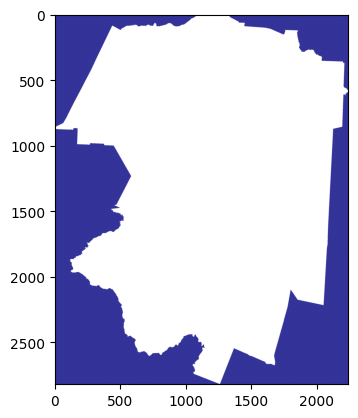

In [132]:
src = rasterio.open(district_raster)
pyplot.imshow(src.read(1), cmap='terrain')
pyplot.show()

In [134]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from matplotlib import pyplot

annual_solar_radiation_raster = f'{root_dir}/test-data/lris-lenz-mean-annual-solar-radiation-GTiff/solar_2193.tif'
slope_raster = f'{root_dir}/test-data/lris-lenz-slope-GTiff/slop_2193.tif'
temperature_raster = f'{root_dir}/test-data/lris-lenz-mean-annual-temperature-GTiff/temperature_2193.tif'
district_shp=f'{root_dir}/output-data/district.shp'
solar_in_district_raster = f'{root_dir}/output-data/solar-in-district.tif'
slope_in_district_raster = f'{root_dir}/output-data/slope-in-district.tif'
temperature_in_district_raster = f'{root_dir}/output-data/temperature-in-district.tif'


RPL_ExtractByMask(annual_solar_radiation_raster, district_shp, solar_in_district_raster)
RPL_ExtractByMask(slope_raster, district_shp, slope_in_district_raster)
RPL_ExtractByMask(temperature_raster, district_shp, temperature_in_district_raster)


In [ ]:
src = rasterio.open(solar_in_district_raster)
pyplot.imshow(src.read(1))
pyplot.show()

In [92]:
gdf = gpd.read_file(district_shp)
print(gdf.total_bounds)

[1861324.2328 5725733.1833 1917200.2137 5796083.9514]


In [135]:
for file in [district_raster,solar_in_district_raster, slope_in_district_raster, temperature_in_district_raster]:
    with rasterio.open(file) as src:
        print(f"File: {file}")
        print(src.meta)
        # print("CRS:", src.crs)
        # print("Bounds:", src.bounds)
        # print("Profile:", src.profile)
        # print("Meta:", src.meta)
        # print("NoData Value:", src.nodata)
        # print("Number of Bands:", src.count)
        # print("Shape:", src.shape)
        # print("Data Types:", src.dtypes)
        # print("Transform:", src.transform)
        print("\n")

File: /Users/landy/UoW/COMPX576/code/site-analyzer/output-data/district-raster.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2241, 'height': 2821, 'count': 1, 'crs': CRS.from_wkt('PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4167"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","2193"]]'), 'transform': Affine(24.94765968545104, 0.0, 1861304.31012581,
       0.0, -24.94765968545104, 5796105.510110664)}


File: /Users/landy/Uo

In [ ]:
# union buffered lake and residential areas in a specific district
buffered_lake_in_district_shp=f'{root_dir}/output-data/buffered-lake-in-district.shp'
buffered_residential_in_district_shp=f'{root_dir}/output-data/buffered-residential-in-district.shp'
unioned_in_district_shp=f'{root_dir}/output-data/unioned-in-district.shp'
gdf1 = gpd.read_file(buffered_lake_in_district_shp)
gdf2 = gpd.read_file(buffered_residential_in_district_shp)
gs_all = gpd.GeoSeries(pd.concat([gdf1.geometry, gdf2.geometry], ignore_index=True), crs=gdf1.crs)

# gs_all.plot(figsize=(10, 10),facecolor='none', edgecolor='black')
unioned =  gpd.GeoSeries([gs_all.union_all()], crs=gs_all.crs)
unioned.plot(figsize=(10, 10), facecolor='none', edgecolor='red')
RPL_Union_analysis([buffered_lake_in_district_shp, buffered_residential_in_district_shp], unioned_in_district_shp)
gpd.read_file(unioned_in_district_shp).plot(figsize=(10, 10), facecolor='none', edgecolor='blue')

In [ ]:
# Create buffer for lake areas in a specific district
lake_in_district_shp=f'{root_dir}/output-data/lake-in-district.shp'
buffered_lake_in_district_shp=f'{root_dir}/output-data/buffered-lake-in-district.shp'
RPL_Buffer_analysis(
    input=lake_in_district_shp,
    output=buffered_lake_in_district_shp,
    buffer_distance=500
)
gpd.read_file(buffered_lake_in_district_shp).plot(figsize=(10, 10))

In [ ]:
# Create buffer for residential areas in a specific district
residential_in_district_shp=f'{root_dir}/output-data/residential-in-district.shp'
buffered_residential_in_district_shp=f'{root_dir}/output-data/buffered-residential-in-district.shp'
RPL_Buffer_analysis(
    input=residential_in_district_shp,
    output=buffered_residential_in_district_shp,
    buffer_distance=1000
)
gpd.read_file(buffered_residential_in_district_shp).plot(figsize=(10, 10))

In [ ]:
# clip the residential polygons to the district boundary
all_residential_shp = f'{root_dir}/test-data/lds-nz-residential-area-polygons-topo-150k-SHP/nz-residential-area-polygons-topo-150k.shp'
district_shp=f'{root_dir}/output-data/district.shp'
residential_in_district_shp=f'{root_dir}/output-data/residential-in-district.shp'
RPL_Clip_analysis(
    output=residential_in_district_shp,
    whole_area=all_residential_shp,
    boundary=district_shp
)

In [ ]:
gpd.read_file(residential_in_district_shp).plot(figsize=(10, 10))

In [ ]:
# clip the lake polygons to the district boundary
all_lake_shp = f'{root_dir}/test-data/lds-nz-lake-polygons-topo-150k-SHP/nz-lake-polygons-topo-150k.shp'
district_shp=f'{root_dir}/output-data/district.shp'
lake_in_district_shp=f'{root_dir}/output-data/lake-in-district.shp'
RPL_Clip_analysis(
    output=lake_in_district_shp,
    whole_area=all_lake_shp,
    boundary=district_shp
)

In [ ]:
gpd.read_file(lake_in_district_shp).plot(figsize=(10, 10))

In [ ]:
# extract a specific district (e.g., '002') from the territorial authority shapefile
input_shp=f'{root_dir}/test-data/statsnz-territorial-authority-2025-clipped-SHP/territorial-authority-2025-clipped.shp'
output_shp=f'{root_dir}/output-data/district.shp'
RPL_Select_analysis(
    input_shp=input_shp,
    output_shp=output_shp,
    conditions_expression=f"TA2025_V1_ == '024'"
)
gpd.read_file(output_shp).plot(figsize=(10, 10))